In [1]:
# from data_aug.data_lvis import DataSetWrapper
# from models.rpn import ProposalNetwork

import matplotlib.pyplot as plt
import numpy as np
import torch, cv2
import skimage.io as io

%load_ext autoreload
%autoreload 2

In [2]:
# sklearn 
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import confusion_matrix, adjusted_mutual_info_score, accuracy_score
from scipy.optimize import linear_sum_assignment
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.manifold import TSNE

In [3]:
## cocoapi related imports
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools.mask import iou
from matplotlib.patches import Polygon
from pycocotools import mask as maskUtils

cocoGt=COCO('/scratch/users/zzweng/datasets/coco/annotations/instances_val2017.json')

#ls = np.array([len(cocoGt.imgToAnns[i]) for i in cocoGt.getImgIds() ])

loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


# Pick an image and visualize GT annotations

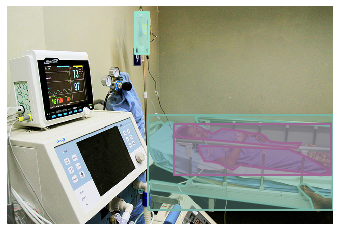

In [4]:
image_id = cocoGt.getImgIds()[90]   # 20784 plane
img = cocoGt.loadImgs([image_id])[0]
I = io.imread(img['coco_url'])
plt.imshow(I); plt.axis('off')

annIds = cocoGt.getAnnIds(imgIds=image_id, iscrowd=None)
anns = cocoGt.loadAnns(annIds)
cocoGt.showAnns(anns, draw_bbox=True)
# plt.imshow(I[142:142+69,236:(236+24),:])

# Visualize rpn output

In [1]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

# from models.hyperbolic_resnet import HResNetSimCLR
from simclr_lvis import prepare_object_pairs
from simclr_lvis import keep

In [2]:
from models.rpn import ProposalNetwork
import skimage
import torchvision.transforms as T
from models.rpn import get_modelzoo_config
from detectron2.config import get_cfg
from detectron2 import model_zoo

In [3]:
rpn = ProposalNetwork(device='cuda')
cfg = rpn.cfg
# cfg.INPUT.FORMAT = 'RGB'

Build Predictor using cfg


In [5]:
# CFG_FILE = "Cityscapes/mask_rcnn_R_50_FPN.yaml"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CFG_FILE))
cfg.INPUT.FORMAT = 'RGB'
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 100
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 50
# cfg.MODEL.WEIGHTS = r'output/model_0003999.pth'  # LVIS weights
# cfg.MODEL.WEIGHTS = r'/scratch/users/zzweng/output/coco/classagnostic1/model_0021999.pth'
# cfg.MODEL.WEIGHTS = r'/scratch/users/zzweng/runs/checkpoints/coco_config_hyp=False_zdim=256_loss=nce/rpn_model_0.pth'
# cfg.MODEL.WEIGHTS = r'/scratch/users/zzweng/output/imagenet/R-101-GN.pkl'
rpn.predictor = DefaultPredictor(cfg)

NameError: name 'model_zoo' is not defined

In [ ]:
image_id = cocoGt.getImgIds()[910]   # 20784 plane
img = cocoGt.loadImgs([image_id])[0]
I = io.imread(img['coco_url'])
plt.imshow(I); plt.axis('off')

annIds = cocoGt.getAnnIds(imgIds=image_id, iscrowd=None)
anns = cocoGt.loadAnns(annIds)
print([a['category_id'] for a in anns])
cocoGt.showAnns(anns, draw_bbox=True)
# plt.imshow(I[142:142+69,236:(236+24),:])

In [ ]:
image = torch.tensor(I)
out = rpn(image)[0]['instances']
# print(out.objectness_logits)
print(len(out))
idx = [i for i in range(len(out.pred_masks)) if keep(i, out.pred_masks)]
out = out[idx]
print(len(out))
v = Visualizer(image.cpu().numpy().astype(np.uint8), 
               MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(out.to("cpu"))
plt.figure()
plt.imshow(v.get_image())

In [28]:
xis_ts, xjs_ts = prepare_object_pairs(out.pred_masks, out.pred_boxes, image.to('cuda'))
xis = xis_ts.cpu().numpy().transpose(0, 2, 3, 1)
xjs = xjs_ts.cpu().numpy().transpose(0, 2, 3, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

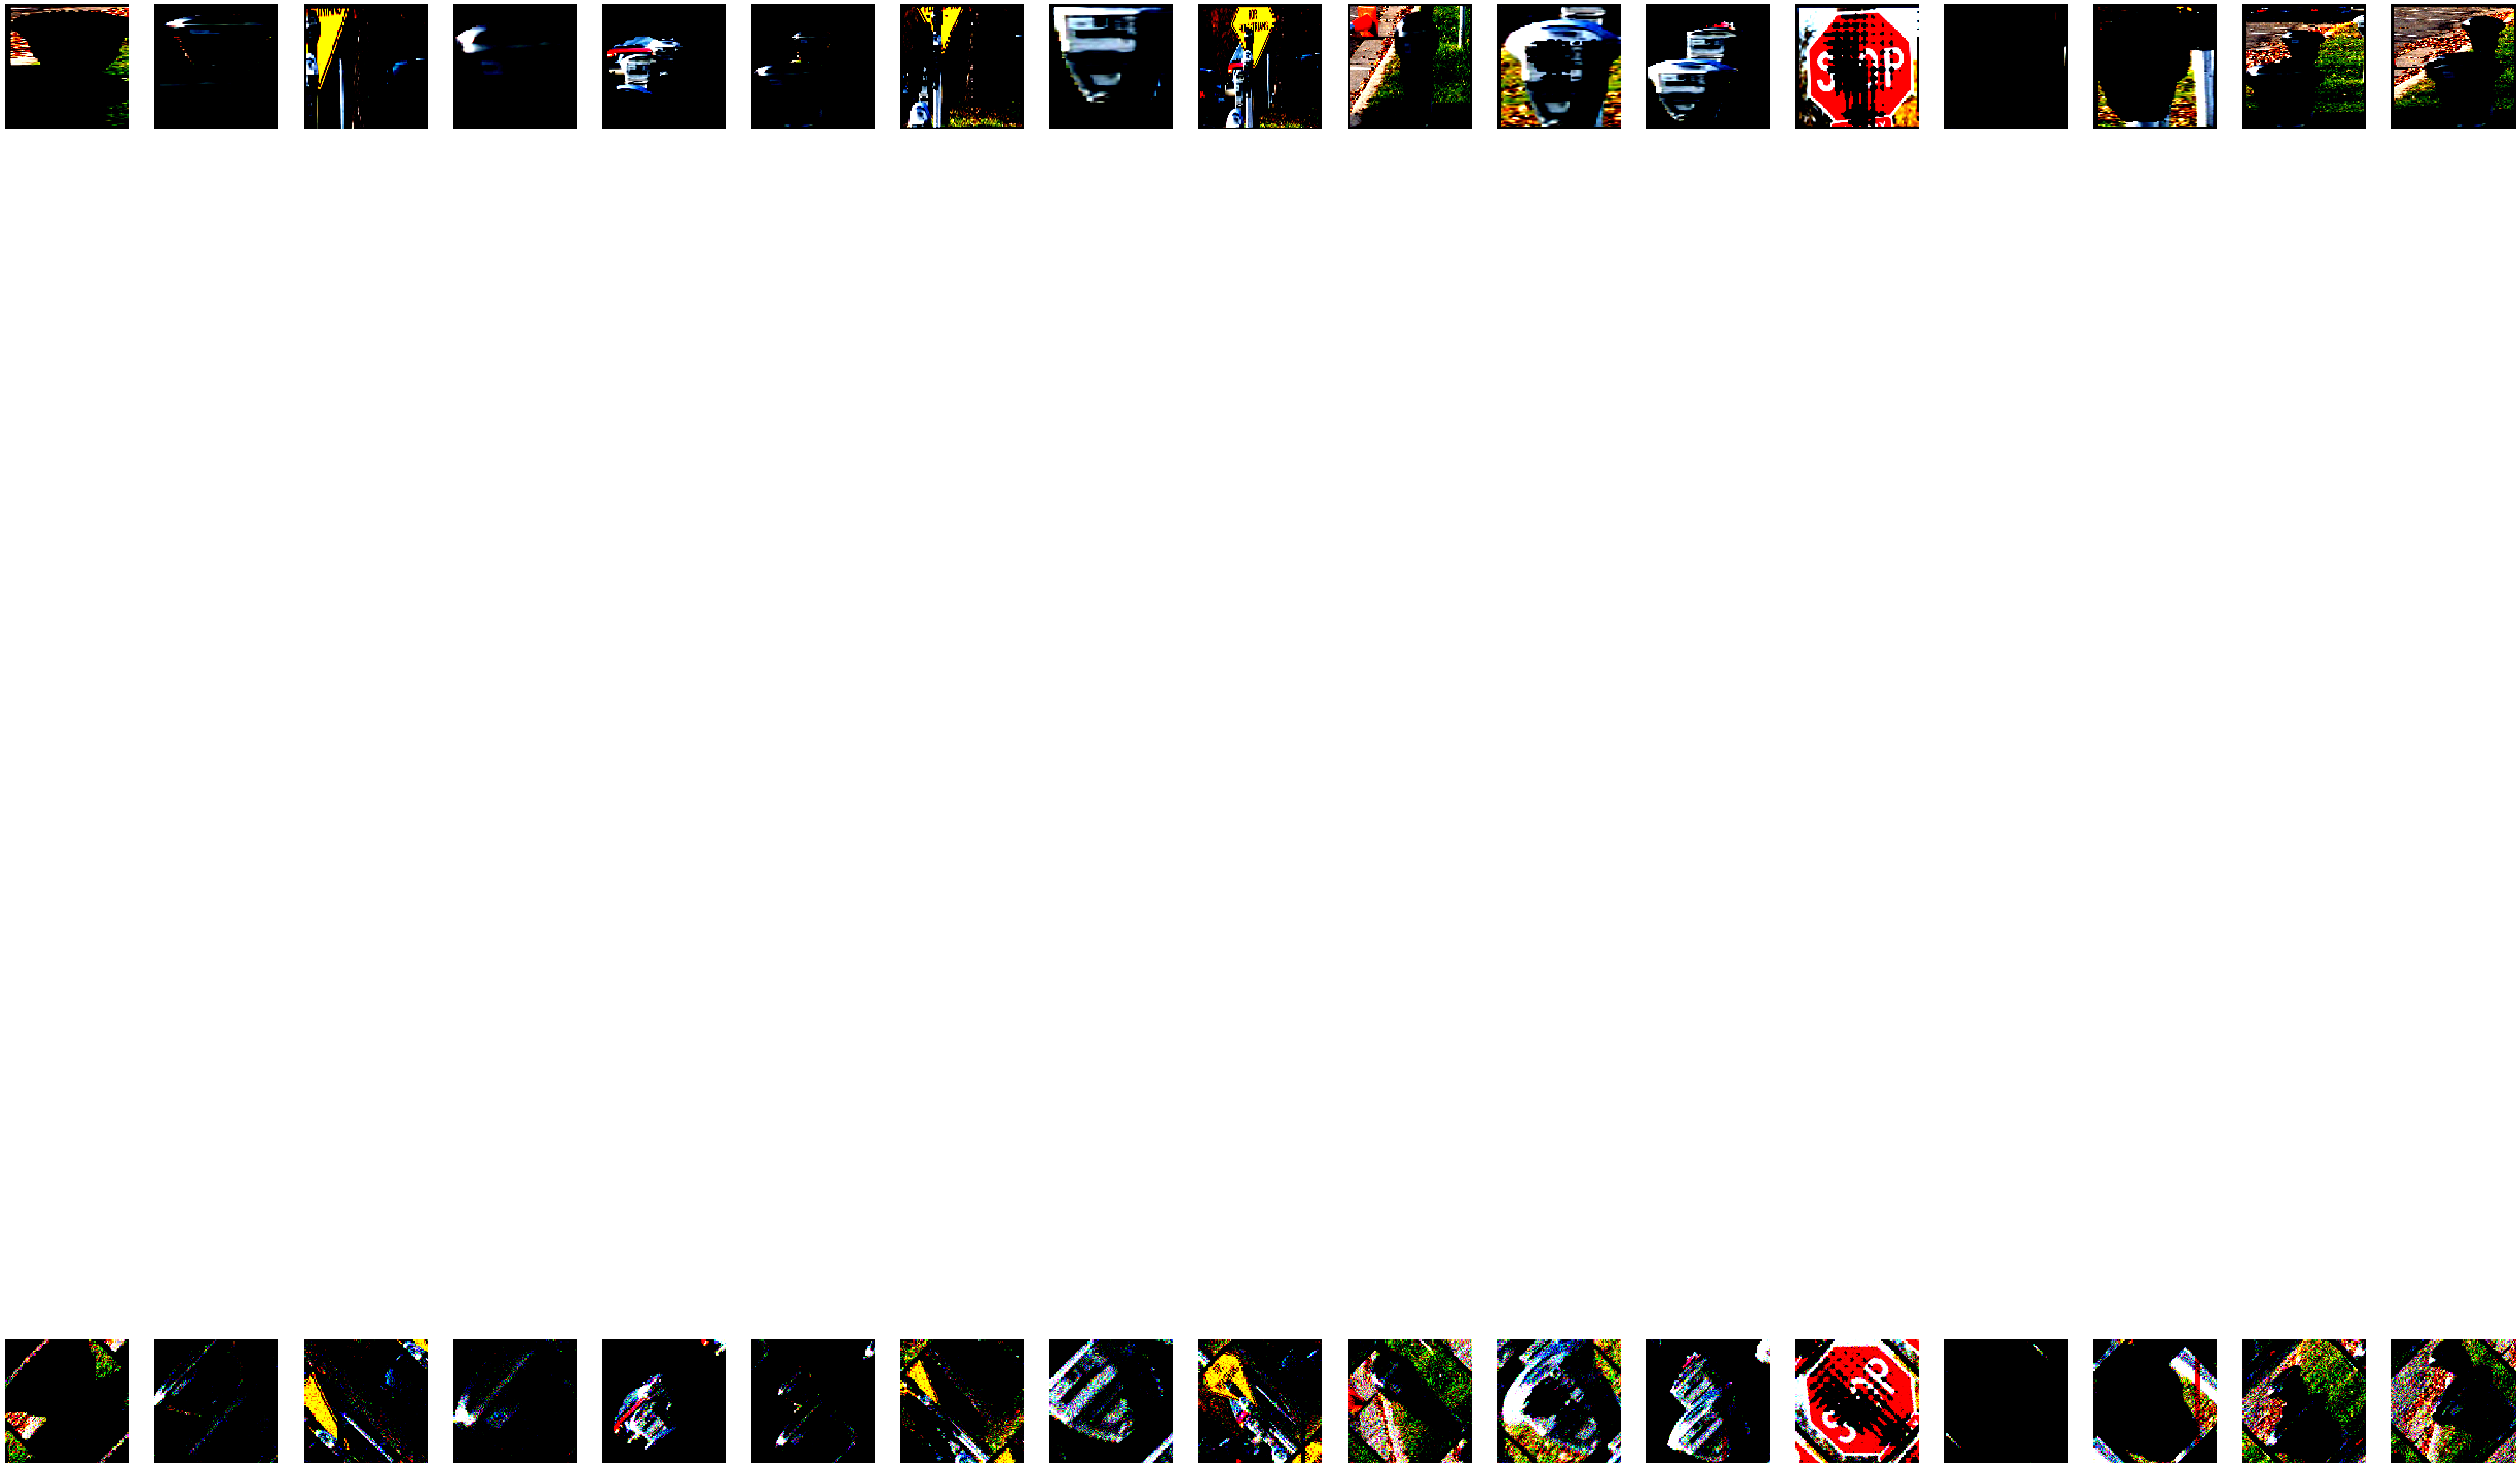

In [29]:
fig, ax = plt.subplots(2, len(xis), figsize=(64,64))
for j in range(len(xis)):
    ax[0][j].imshow(xis[j])
    ax[0][j].axis('off')
    ax[1][j].imshow(xjs[j])
    ax[1][j].axis('off')

# Feature Evaluation

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from collections import Counter

import torchvision
import torch.nn as nn

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
from models.resnet_simclr import ResNetSimCLR
cmodel = ResNetSimCLR('alexnet', out_dim=256)
# cmodel.load_state_dict(torch.load(r'resnet18_80-epochs/checkpoints/model.pth'))   # pretrained on STL-10
cmodel.load_state_dict(torch.load(
    r'/scratch/users/zzweng/runs/checkpoints/coco_config_hyp=False_zdim=256_loss=nce//model_45000.pth'))

## Load all annotations in selected images

In [ ]:
len(cocoGt.anns), len(cocoGt.getImgIds())

In [ ]:
patch_data = np.load('patch_x_224_ml_mask.npy')/255.
feature_y_arr = np.load('patch_y_224_ml_mask.npy')
patch_data_tensor = torch.tensor(patch_data)
patch_data_tensor.shape, feature_y_arr.shape

In [ ]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [ ]:
patch_data_tensor = torch.stack([normalize(patch_data_tensor[i]/255.) for i in range(len(patch_data_tensor))])

In [ ]:
np.load('patch_x_224_ml_mask.npy').itemsize

In [ ]:
plt.imshow(patch_data_tensor[2].permute(1,2,0))

# Feed the patches to pretrained model and get representations

In [ ]:
cmodel_ = torchvision.models.resnet101(pretrained=True)
cmodel = nn.Sequential(*list(cmodel_.children())[:-1])
cmodel.eval()

In [ ]:
batch_size = 32
X_all = []
for i in tqdm(range(len(patch_data_tensor)//32 + 1)):
    batch = patch_data_tensor[i*batch_size:(i+1)*batch_size]
    X_all.append(cmodel(batch.float()).view(len(batch), -1).detach().cpu().numpy())
X_all = np.concatenate(X_all)
y_all = feature_y_arr
X_all.shape, y_all.shape

In [ ]:
sorted(Counter(feature_y_arr).items(), key=lambda tup: -tup[1])

## Sample a few classes and get the representations

In [ ]:
# with open("imagenet1000_clsidx_to_labels.txt") as f:
#     idx2label = eval(f.read())

In [ ]:
X, y = [], []
k = 25
cat_list = [1, 3, 4, 5, 52, 25]
for cat_id in tqdm(cat_list):
    distinct_count = Counter(feature_y_arr)[cat_id]
    if distinct_count > k:
        idx = np.random.choice(np.where(feature_y_arr==cat_id)[0], k, replace=False)
    else:
        idx = np.where(feature_y_arr==cat_id)[0]
    h = cmodel(patch_data_tensor[idx].float()).view(len(idx), -1) 
    
    X.append(h.detach().cpu().numpy())
    y.extend([cat_id]*len(idx))
X = np.concatenate(X)
y = np.array(y)
X.shape, y.shape

## Classifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
X_train.shape, X_test.shape

In [ ]:
def linear_model_eval(X_train, y_train, X_test, y_test):
    clf = LogisticRegression(random_state=0, max_iter=1200, solver='lbfgs', C=1.0)
    clf.fit(X_train, y_train)
    print("Logistic Regression feature eval")
    print("Train score:", clf.score(X_train, y_train))
    print("Test score:", clf.score(X_test, y_test))
    neigh = KNeighborsClassifier(n_neighbors=5, weights='distance')
    neigh.fit(X_train, y_train)
    print("KNN feature eval")
    print("Train score:", neigh.score(X_train, y_train))
    print("Test score:", neigh.score(X_test, y_test))

In [ ]:
linear_model_eval(X_train, y_train, X_test, y_test)

In [ ]:
kmeans = KMeans(6)
clusters = kmeans.fit_predict(X)

In [ ]:
y_map = dict(zip(set(y_all), range(len(set(y_all)))))
y_map_rev = dict(zip(range(len(set(y_all))), set(y_all)))
y_mapped = np.array([y_map[i] for i in y_all])
cfm = confusion_matrix(clusters, y_mapped)
row_ind, col_ind = linear_sum_assignment(-cfm)
label_map = dict(zip(row_ind, col_ind))
clusters_mapped = np.array([label_map[u] for u in clusters])
cfm_mapped = confusion_matrix(clusters_mapped, y_mapped)

accuracy_score(y_mapped, clusters_mapped), adjusted_mutual_info_score(y_mapped, clusters_mapped)

In [ ]:
y_map = dict(zip(set(y), range(len(set(y)))))
y_map_rev = dict(zip(range(len(set(y))), set(y)))
y_mapped = np.array([y_map[i] for i in y])
cfm = confusion_matrix(clusters, y_mapped)
row_ind, col_ind = linear_sum_assignment(-cfm)
label_map = dict(zip(row_ind, col_ind))
clusters_mapped = np.array([label_map[u] for u in clusters])
cfm_mapped = confusion_matrix(clusters_mapped, y_mapped)

accuracy_score(y_mapped, clusters_mapped), adjusted_mutual_info_score(y_mapped, clusters_mapped)

In [ ]:
confusion_matrix(y_mapped, clusters_mapped)

# Predicted classes for the patches

In [ ]:
import scipy.stats

In [ ]:
X_dt = cmodel(torch.tensor(xis.transpose(0, 3, 1, 2))).view(len(xjs), -1).detach().numpy()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)#, weights='distance')
knn.fit(X, y)

knn.kneighbors(X_dt)

In [ ]:
pred_class = [label_map[u] for u in kmeans.predict(X_dt)]
pred_class_coco = [y_map_rev[u] for u in pred_class]

In [ ]:
pred_class_coco

## Projections

In [ ]:
tsne = TSNE(n_components=2, perplexity=20)
tsne_vec = tsne.fit_transform(X)

In [ ]:
colors = ['r', 'g', 'b', 'cyan', 'yellow', 'k', 'm']
cmap = dict(zip(Counter(y).keys(), colors))
plt.scatter(tsne_vec[:,0], tsne_vec[:,1], c=[cmap[i] for i in y])

In [ ]:
cmap = dict(zip(set(clusters), colors))
plt.scatter(tsne_vec[:,0], tsne_vec[:,1], c=[cmap[i] for i in clusters])

In [ ]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_all)
neigh = KNeighborsClassifier(n_neighbors=5)#, weights='distance')
neigh.fit(scaler.transform(X_all), y_all)

In [ ]:
confusion_matrix(y_test, neigh.predict(scaler.transform(X_test)))

In [ ]:
neigh.predict(scaler.transform(X_test))

In [ ]:
i = 1
nbrs = neigh.kneighbors(X_test)[1]
print('NN categories:', y_all[nbrs[i]])
print('True category:', y_test[i])

plt.imshow(patch_data_tensor[nbrs[i][1]].permute(1,2,0))

Old Code

In [ ]:
from clustering.hkmeans import HyperbolicKMeans
hkm = HyperbolicKMeans(62)
hclusters = hkm.fit_predict(feature_x_arr)

# clusters = GaussianMixture(n_components=59).fit_predict(feature_x_arr)
gm = GaussianMixture(n_components=59).fit(feature_x_arr)
soft_prob = gm.predict_proba(feature_x_arr+0.01)

In [ ]:
# import torch, torchvision
# from torch.utils.tensorboard import SummaryWriter

# # Writer will output to ./runs/ directory by default
# writer = SummaryWriter('runs/embeddings')
# # (N, D), metadata= (N), label_img=(N, C, H, W)
# # writer.add_embedding(torch.randn(100, 5), metadata=meta, label_img=label_img)
# # writer.add_embedding(torch.randn(100, 5), label_img=label_img)
# writer.add_embedding(feature_h_arr, metadata=feature_y_arr)

# writer.close()

In [ ]:
pca = PCA(101)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

lm = LogisticRegression(max_iter=1000).fit(X_train_pca, y_train)

In [ ]:
pred = lm.predict(X_train_pca)
accuracy_score(y_train, pred)

In [ ]:
pred = lm.predict(X_test_pca)
accuracy_score(y_test, pred)

In [ ]:
tsne = TSNE(n_components=2, perplexity=50).fit_transform(X)
plt.scatter(tsne[:,0], tsne[:,1], c=y)

In [ ]:
Counter(y)